#Sistem Rekomendasi mencari lokasi wisata di Indonesia

Sistem digunakan untuk meberikan rekomendasi nama destinasi lokasi wisata berdasarkan cotent bases filtering (yang digunakan adalah nama lokasi yang di filter berdasarkan kesamaan lokasi/kota)

## Data Source
Data diambil dari kaggle, terdapat 4 file di dalam file zip

[Source data Indonesia Tourism Destination](https://www.kaggle.com/aprabowo/indonesia-tourism-destination)

Import semua Library yang akan digunakan, import dilakukan pada proses awal karena untuk mempermudah proses pengerjaan.

In [2]:
!pip install kaggle

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from google.colab import files
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

Karena Data diambil dari kaggle, untuk mempermudah proses load data bisa menggunakan library kaggle.

Install kaggle, lalu upload file key token yang telah di *generate*  dari account yang dimiliki. Lalu membuat direktory baru bernama kaggle, pindah data kaggle.json yang sudah kita upload, arahkan ke folder kaggle yang sudah dibuat sebelumnya, lalu atur *permission access* supaya owner/user, grup, other bisa untuk *read, write and execution* terhadap data kaggle.json dengan menggunakan ```chmood 600```

In [3]:
upload = files.upload()
for k in upload.keys():
  print(k)

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


## Data Loading

Download dataset Indonesia torism destination dengan menggunakan API kaggle file akan disimpan dalam ```/content/```

In [4]:
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 61.2MB/s]


### Unzip File zip

Setelah data di download, ternyata data berbentuk file zip, yang didalamnya terdapat 4 file csv yaitu:
1. tourism_ with_id.csv : file ini berisi informasi lokasi wisata dari 5 kota di Indonesia 
2. user.csv : file ini berisi mengenai data pengguna (data dummy)
3. tourism_rating.csv : file ini berisi mengenai data rating dari bebrapa tempat lokasi wissata yang diberikan oleh user 
4. package_tourism.csv : file ini berisi package lokasi wisata

Buat satu directory yang berfungsi untuk menampung data dari indonesia-tourism-destination.zip dengan menggunakan 

```!mkdir name_directory```

untuk ektract data zip bisa menggunakan script 



```
!unzip -q indonesia-tourism-destination.zip
```
kenapa terdapat -q didalam script ```!unzip``` dikarenakan untuk menyembunyikan comment yang muncul


In [5]:
!mkdir -p /content/destination_tourism
!unzip -q indonesia-tourism-destination.zip -d /content/destination_tourism

### Load Data
Load data masing-masing file kedalam variable yang mengambarkan nama dari file tersebut, data di load dengan menggunakan library **Pandas**

Kemudian cek berapa jumlah masing-masing data dalam varible tersebut dengan menggunkan fungsi ```len()```

In [6]:
package_tourism = pd.read_csv('/content/destination_tourism/package_tourism.csv')
tourism_rating = pd.read_csv('/content/destination_tourism/tourism_rating.csv')
tourism_user = pd.read_csv('/content/destination_tourism/user.csv')
tourism_info = pd.read_csv('/content/destination_tourism/tourism_with_id.csv')

print(f'Jumlah data package tourism : {len(package_tourism)}')
print(f'Jumlah data tourism rating: {len(tourism_rating)}')
print(f'Jumlah user: {len(tourism_user)}')
print(f'jumlah information tourism: {len(tourism_info)}')

Jumlah data package tourism : 100
Jumlah data tourism rating: 10000
Jumlah user: 300
jumlah information tourism: 437


Setelah data csv di baca dan di letakkan pada variable diketahui bahwa data package tourism berjumlah 100 data rating berjumlah 10.000 jumlah user 300 dan jumlah tempat wisata 437

## Exploratory Data Unvariate

Setelah setiap file csv di deklarasikan ke dalam sebuah variable maka data per variable akan di analisis untuk mengetahui apa jenis data yang ada.

### Explorasi package tourism


In [7]:
package_tourism

,Package,City,Place_Tourism1,Place_Tourism2,Place_Tourism3,Place_Tourism4,Place_Tourism5
0,1,Jakarta,Pasar Tanah Abang,Taman Ayodya,Museum Tekstil,NaN,NaN
1,2,Jakarta,Pasar Tanah Abang,Pasar Taman Puring,Pasar Petak Sembilan,NaN,NaN
2,3,Jakarta,Perpustakaan Nasional,Monas,Masjid Istiqlal,NaN,NaN
3,4,Jakarta,Pulau Tidung,Pulau Bidadari,Pulau Pari,Pulau Pramuka,Pulau Pelangi
4,5,Jakarta,Museum Satria Mandala,Museum Wayang,Museum Bahari Jakarta,Museum Macan (Modern and Contemporary Art in N...,NaN
...,...,...,...,...,...,...,...
95,96,Surabaya,Ekowisata Mangrove Wonorejo,Taman Harmoni Keputih,Taman Kunang-Kunang,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank
96,97,Surabaya,Ciputra Waterpark,Kenjeran Park,Kebun Binatang Surabaya,Food Junction Grand Pakuwon,| Atlantis Land Surabaya
97,98,Surabaya,Museum Kesehatan Dr. Adhyatma,Patung Buddha Empat Rupa,Taman Hiburan Rakyat,Taman Bungkul,Taman Flora Bratang Surabaya
98,99,Surabaya,Taman Ekspresi Dan Perpustakaan,Museum De Javasche Bank,Surabaya Museum (Gedung Siola),Museum Mpu Tantular,Taman Air Mancur Menari Kenjeran


In [8]:
package_tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Package         100 non-null    int64 
 1   City            100 non-null    object
 2   Place_Tourism1  100 non-null    object
 3   Place_Tourism2  100 non-null    object
 4   Place_Tourism3  100 non-null    object
 5   Place_Tourism4  66 non-null     object
 6   Place_Tourism5  39 non-null     object
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


Data package tourism berisi 7 kolom dengan 100 baris, variable kolom (Package, city, place_tourism1, place_tourism2, place_tourism3, place_tourism4) dengan package memiliki type data integer sedangan untuk 5 variable kolom lainnya bertype string/object

### Ekplorasi data *Tourism Ratings*

In [9]:
tourism_rating

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [10]:
tourism_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


Pada data rating memiliki 3 kolom (User Id, place Id, place Ratting) dengan type data integer
* user id = untuk id user
* place id = untuk id dari tempat/lokasi wisata
* Place rating = untuk rating setiap lokasi yang diberikan user

lalu untuk mengetahui berapa nilai dari min-max rating maka diperlukan deskripsi statistika digunakan fungsi ```data.describe()```

In [11]:
tourism_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
User_Id,10000.0,151.2927,86.137374,1.0,77.00,151.0,226.0,300.0
Place_Id,10000.0,219.4164,126.228335,1.0,108.75,220.0,329.0,437.0
Place_Ratings,10000.0,3.0665,1.379952,1.0,2.00,3.0,4.0,5.0


Diketahui nilai minimum rating adalah 1.0 dan maximum rating adalah 5.0 dengan jumlah data 10000




In [12]:
tourism_rating.corr()

,User_Id,Place_Id,Place_Ratings
User_Id,1.000000,0.00023,-0.070832
Place_Id,0.000230,1.00000,0.003190
Place_Ratings,-0.070832,0.00319,1.000000


Plot data dengan rating sebagai x dan Place Id sebagai y

<function matplotlib.pyplot.show>

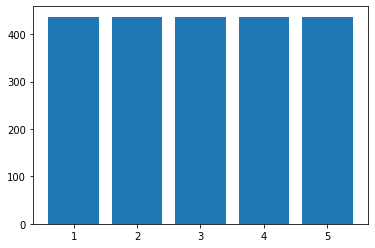

In [13]:
plt.bar(tourism_rating['Place_Ratings'], tourism_rating['Place_Id'])
plt.show

### Eksplorasi data User

In [14]:
tourism_user

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20
...,...,...,...
295,296,"Lampung, Sumatera Selatan",31
296,297,"Palembang, Sumatera Selatan",39
297,298,"Bogor, Jawa Barat",38
298,299,"Sragen, Jawa Tengah",27


In [15]:
tourism_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


Diketahui data user berjumlah 300 dengan nama kolom user_id, location(asal user) dan age
Data akan ditampilkan dalam visualisasi, data akan di petakan berdasarkan user_Id dan asal provinsi dari user.

Dikarenakan data lokasi belum terpisah antara nama kota dan provinsi maka data lokasi akan dipecah menjadi kota dan provinsi.

In [16]:
tourism_user[['kota', 'provinsi']] = tourism_user['Location'].str.split(',', expand=True)
tourism_user

,User_Id,Location,Age,kota,provinsi
0,1,"Semarang, Jawa Tengah",20,Semarang,Jawa Tengah
1,2,"Bekasi, Jawa Barat",21,Bekasi,Jawa Barat
2,3,"Cirebon, Jawa Barat",23,Cirebon,Jawa Barat
3,4,"Bekasi, Jawa Barat",21,Bekasi,Jawa Barat
4,5,"Lampung, Sumatera Selatan",20,Lampung,Sumatera Selatan
...,...,...,...,...,...
295,296,"Lampung, Sumatera Selatan",31,Lampung,Sumatera Selatan
296,297,"Palembang, Sumatera Selatan",39,Palembang,Sumatera Selatan
297,298,"Bogor, Jawa Barat",38,Bogor,Jawa Barat
298,299,"Sragen, Jawa Tengah",27,Sragen,Jawa Tengah


Setelah data dipecah data akan divisualisasikan dengan menggunakan barplot User_Id sebagai height

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


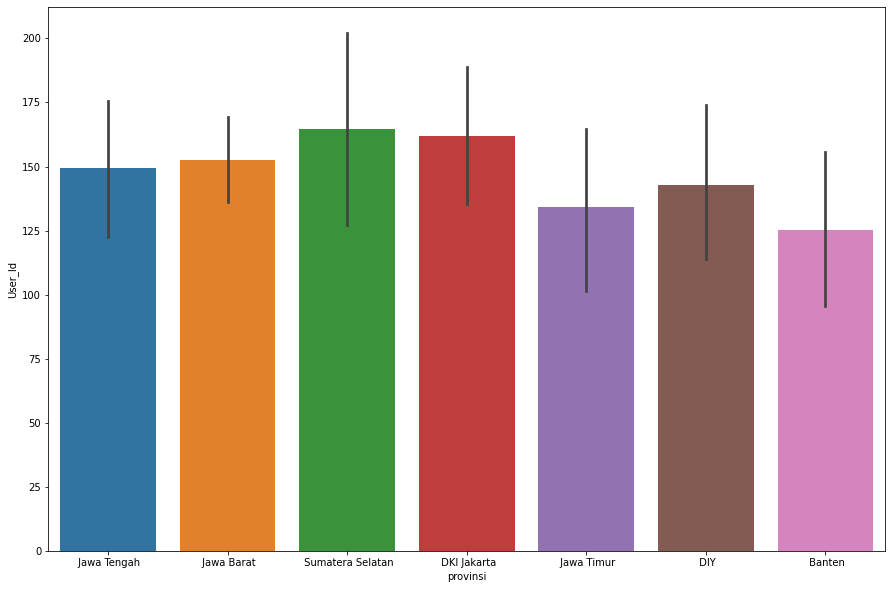

In [17]:
plt.figure(figsize=(15, 10))
sns.barplot(tourism_user['provinsi'], tourism_user['User_Id'])
plt.show()

### Eksplorasi data Tourism information

In [18]:
tourism_info

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906,NaN,433
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822,NaN,434
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938,NaN,435
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753,NaN,436


In [19]:
tourism_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


Di dalam file tourism_info terdapat 13 kolom tetapi, ada 2 kolom dengan nama yang tidak jelas/tidak bisa dipahami maka kolom tersebut akan dihapus.

In [20]:
tourism_inform = tourism_info.loc[:, ~tourism_info.columns.str.contains('^Unnamed')]
tourism_inform

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,45.0,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,45.0,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,NaN,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753


Diketahui bahwa :
- Place-Id : id untuk tempat wisata
- Place_Name: Nama dari lokasi wisata
- Description: penjelasan singkat mengenai tempat wisata tersebut
- Category: wisata termasuk dalam kategori apa(budaya, taman-hiburan dll)
- City: Lokasi tempat wisata(kota)
- Price: biaya masuk ke lokasi wisata 
- Rating : tingkat kepuasan pelanggan
- Time_Minutes: waktu perjalanan
- Coordinate: koordinat dari lokasi wisata
- Lat: Garis Lintang
- Long: Garis Bujur

Variable tourism_info memiliki 437 data, karena di dalam minut terdapat nan/missing value, makan missing value tersebut diganti dengan nilai rata-rata dari data pada column tersebut.


In [21]:
tourism_inform.isna().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64

Data time minutes memiliki banyak missing value, kalau data row yang mengandung missing value dihapus maka akan berakibat berkurangnya data hampir 50% sehingga untuk mengatasi itu, dipilih untuk drop data time_minus dari dataFrame, untuk mencegah kehilangan data yang banyak.


In [22]:
tourism_inform = tourism_inform.drop(columns=["Time_Minutes"])
tourism_inform

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134
...,...,...,...,...,...,...,...,...,...,...
432,433,Museum Mpu Tantular,Museum Negeri Mpu Tantular adalah sebuah museu...,Budaya,Surabaya,2000,4.4,"{'lat': -7.4338593, 'lng': 112.7199058}",-7.433859,112.719906
433,434,Taman Bungkul,Taman Bungkul adalah taman wisata kota yang te...,Taman Hiburan,Surabaya,0,4.6,"{'lat': -7.291346799999999, 'lng': 112.7398218}",-7.291347,112.739822
434,435,Taman Air Mancur Menari Kenjeran,Air mancur menari atau dancing fountain juga a...,Taman Hiburan,Surabaya,0,4.4,"{'lat': -7.2752955, 'lng': 112.7549381}",-7.275296,112.754938
435,436,Taman Flora Bratang Surabaya,Taman Flora adalah salah satu taman kota di Su...,Taman Hiburan,Surabaya,0,4.6,"{'lat': -7.294330299999999, 'lng': 112.7617534}",-7.294330,112.761753


## Content Based Filtering

### Data Processing

Data akan diproses untuk membuat sistem rekomendasi berdasarkan content.

Karena ingin membuat sistem content based filtering, data yang digunakan berasal data rating pengggunka yang akan digabung dengan data detail lokasi wisata. 

Gabungkan data tourism_rating dengan data tourism_inform

In [23]:
rate_tourism = pd.merge(tourism_rating, tourism_inform,
                        on='Place_Id', how='left')
rate_tourism.head(2)

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,Yogyakarta,75000,4.6,"{'lat': -7.7705416, 'lng': 110.4894158}",-7.770542,110.489416
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Bahari,Semarang,3000,4.1,"{'lat': -6.948877, 'lng': 110.3893285}",-6.948877,110.389328


Data digabungkan berdasarakan kesamaan place ID data awal akan ditaruh di sebelah kiri dan data akhir berada di sebelah kanan.

Setelah data digabungkan cek di dalam penggabungan data tersebut, apakah terdaat missing value atau tidak.


In [24]:
rate_tourism.isna().values.any()

False

Setelah di cek ternyata tidak ada data yang mengalami missing value

Dikarenakan data yang akan digunakan untuk content based filtering hanya 

data yang terdapat pada dataFrame rating_tourism dan tourism_inform untuk lokasi, nama tempat dan categori tempat wisata, maka data akan digabungkan sesuai dengan yang dibutuhkan berdasarakan place_idnya

In [25]:
tourism_spot = pd.merge(tourism_rating, 
                        tourism_inform[['Place_Id', 'Place_Name',
                                        'City', 'Category']])
tourism_spot

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category
0,1,179,3,Candi Ratu Boko,Yogyakarta,Budaya
1,22,179,4,Candi Ratu Boko,Yogyakarta,Budaya
2,40,179,3,Candi Ratu Boko,Yogyakarta,Budaya
3,49,179,5,Candi Ratu Boko,Yogyakarta,Budaya
4,74,179,3,Candi Ratu Boko,Yogyakarta,Budaya
...,...,...,...,...,...,...
9995,240,140,3,Bendung Lepen,Yogyakarta,Taman Hiburan
9996,247,140,4,Bendung Lepen,Yogyakarta,Taman Hiburan
9997,261,140,4,Bendung Lepen,Yogyakarta,Taman Hiburan
9998,267,140,3,Bendung Lepen,Yogyakarta,Taman Hiburan


Mengecek Nama kota apa saja yang terdapat dalam dataset kemudian mengurutkan dataset berdasarakan place_Id nya.

In [26]:
tourism_spot.City.unique()

array(['Yogyakarta', 'Semarang', 'Jakarta', 'Bandung', 'Surabaya'],
      dtype=object)

Data terdiri dari lima kota di Indonesia yaitu Yogyakarta, Semarang, Jakarta, Bandung dan Surabaya

data akan disimpan dalam variable data_preparation dan diurutkan berdasarakan Place_Id nya

In [27]:
data_preparation = tourism_spot
data_preparation.sort_values('Place_Id')

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category
9275,36,1,4,Monumen Nasional,Jakarta,Budaya
9292,265,1,4,Monumen Nasional,Jakarta,Budaya
9291,254,1,5,Monumen Nasional,Jakarta,Budaya
9290,235,1,4,Monumen Nasional,Jakarta,Budaya
9289,227,1,5,Monumen Nasional,Jakarta,Budaya
...,...,...,...,...,...,...
1078,234,437,3,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah
1077,222,437,2,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah
1076,217,437,1,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah
1083,270,437,1,Gereja Perawan Maria Tak Berdosa Surabaya,Surabaya,Tempat Ibadah


Data yang digunakan adalah data yang bersifat unique sehingga data yang mengalami duplicate akan dihapus

In [28]:
#cek data duplicate 
data_preparation['Place_Id'].duplicated().sum()

9563

In [29]:
#cek lokasi duplicate
data_preparation.loc[(data_preparation.duplicated())]

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category
92,87,373,3,Museum Kereta Ambarawa,Semarang,Budaya
545,26,15,2,Pasar Seni,Jakarta,Pusat Perbelanjaan
651,1,328,2,Gua Pawon,Bandung,Cagar Alam
672,273,328,4,Gua Pawon,Bandung,Cagar Alam
691,133,307,4,Perkebunan Teh Malabar,Bandung,Cagar Alam
...,...,...,...,...,...,...
9535,184,87,4,Sindu Kusuma Edupark (SKE),Yogyakarta,Taman Hiburan
9739,235,232,5,Bukit Moko,Bandung,Cagar Alam
9743,263,232,5,Bukit Moko,Bandung,Cagar Alam
9938,157,350,3,Pantai Cipta,Semarang,Bahari


Diketahui bahwa data yang mengalami duplicate sebanyak 9563 maka data akan di drop/hapus berdasarkan nilai yang mengalami duplicated berdasarkan place_Id

In [30]:
data_preparation = data_preparation.drop_duplicates('Place_Id')
data_preparation

,User_Id,Place_Id,Place_Ratings,Place_Name,City,Category
0,1,179,3,Candi Ratu Boko,Yogyakarta,Budaya
24,1,344,2,Pantai Marina,Semarang,Bahari
57,1,5,5,Atlantis Water Adventure,Jakarta,Taman Hiburan
82,1,373,3,Museum Kereta Ambarawa,Semarang,Budaya
110,1,101,4,Kampung Wisata Sosro Menduran,Yogyakarta,Budaya
...,...,...,...,...,...,...
9914,62,370,1,Benteng Pendem,Semarang,Budaya
9930,74,350,4,Pantai Cipta,Semarang,Bahari
9948,75,10,2,Pulau Tidung,Jakarta,Bahari
9962,78,7,4,Kebun Binatang Ragunan,Jakarta,Cagar Alam


Data hanya tersisa 437 kolom

Kemudian data akan per column akan dirubah ke dalam per variable data dengan jenis data list.
Kemudian data akan dibuat per dictionary

In [31]:
id = data_preparation['Place_Id'].tolist()
city = data_preparation['City'].tolist()
category = data_preparation['Category'].tolist()
name = data_preparation['Place_Name'].tolist()

# add to directory =
data_dict = pd.DataFrame({
    'place_id' : id,
    'place_name' : name,
    'place_city' : city,
    'place_category': category
})

data_dict.head()

,place_id,place_name,place_city,place_category
0,179,Candi Ratu Boko,Yogyakarta,Budaya
1,344,Pantai Marina,Semarang,Bahari
2,5,Atlantis Water Adventure,Jakarta,Taman Hiburan
3,373,Museum Kereta Ambarawa,Semarang,Budaya
4,101,Kampung Wisata Sosro Menduran,Yogyakarta,Budaya


### TFIDF (Matrix)

Untuk melakukan Content Filtering disini menggunakan TfidVectorizer yang berfungsi untuk konveri/merubah raw document menjadi matrix.

Data yang akan dirubah menjadi matrix adalah data City/nama Kota

In [32]:
vector = TfidfVectorizer()
vector.fit(data_dict['place_city'])
vector.get_feature_names()

['bandung', 'jakarta', 'semarang', 'surabaya', 'yogyakarta']

Data City memiliki 5 lokasi/kota yaitu :
* bandung
* Surabaya
* Jakarta 
* yogyakarta
* Semarang

`fit` digunakan untuk mempelajari kosakata dari data yang akan digunakan

`fit_transform` digunakan untuk mempelajari kosakata dan diubah menjadi IDF yang memberikan nilai berupa matrix


In [33]:
matrix = vector.fit_transform(data_dict['place_city'])

matrix.shape

(437, 5)

Data hasil konversi disimpan dalam variable matrix, data ini memiliki ukuran (437, 5), nilai 5 diambil dari 5 kota(feature yang berada pada place_city)

Data lalu akan dirubah menjadi satu dataFrame, didalam dataframe tersebut data hasil matrix akan dirubah menjadi vektor dengan menggunakan `.todense()` 

Data akan diambil 5 sample untuk sumbu x dan sumbu y

In [34]:
pd.DataFrame(
    matrix.todense(),
    columns = vector.get_feature_names(),
    index = data_dict.place_name,
).sample(5, axis=0).sample(5, axis=1)

,semarang,bandung,jakarta,surabaya,yogyakarta
place_name,,,,,
Surabaya North Quay,0.0,0.0,0.0,1.0,0.0
Bumi Perkemahan Batu Kuda,0.0,1.0,0.0,0.0,0.0
Gereja Katedral Santo Petrus Bandung,0.0,1.0,0.0,0.0,0.0
Pantai Ancol,0.0,0.0,1.0,0.0,0.0
Pantai Glagah,0.0,0.0,0.0,0.0,1.0


Diketahui bahwa seiap tempat akan berkorelasi dengan city/kota yang ditandai dengan nilai 1.0

Contoh Goa Gong memiliki nilai 1.0 pada kota Semarang, jadi Goa Gong terletak di semarang

### Cosine Similarity
Berfungsi untuk mengitung kesamaan data antar nama lokasi wisata.
Library yang digunakan adalah cosine_similarity



\begin{align}
  K(X, Y) = \frac{<X, Y>}{(||X|| * ||Y||}
\end{align}


In [35]:
similarity = cosine_similarity(matrix)

In [36]:
similarity

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

Data hasil perhitungan kesaamaan atar fitur akan disimpan dalam variable dataframe. 

In [37]:
similarity_to_df = pd.DataFrame(
    similarity,
    columns = data_dict.place_name,
    index = data_dict.place_name,
)
print(f'Ukuran dari similarity : {similarity_to_df.shape}')
similarity_to_df.sample(5, axis=0).sample(5, axis=1)

Ukuran dari similarity : (437, 437)


place_name,Museum Konferensi Asia Afrika,Taman Keputran,Museum Ullen Sentalu,Candi Prambanan,Sendang Geulis Kahuripan
place_name,,,,,
Pulau Pramuka,0.0,0.0,0.0,0.0,0.0
Durian Gardens and Tourism Education Watu Simbar,0.0,0.0,0.0,0.0,0.0
Pantai Patihan,0.0,0.0,1.0,1.0,0.0
Rabbit Town,1.0,0.0,0.0,0.0,1.0
Taman Begonia,1.0,0.0,0.0,0.0,1.0


Berdasarkan data diatas dikatahui bahwa data Pasar Beringharjo memiliki kesamaan dengan De Mata Museum Jogja, data diatas hanya diambil sample 5 saja

### Modeling

Membuat sistem rekomendasi berdasarkan kesamaan data yang diambil dari kesamaan kotanya

In [38]:
def recomended_city_tourism(place_name,
                            similarity_name=similarity_to_df,
                            items=data_dict[['place_name', 'place_city']], 
                            n=20):
  i = similarity_name.loc[place_name].to_numpy().argpartition(
      range(-1, -n, -1)
  )
  h_index = similarity_name.columns[i[-1:-(n+1):-1]]
  h_index = h_index.drop(place_name, errors='ignore')
  return pd.DataFrame(h_index).merge(items).head(n)

Karena ingin meminta rekomendasi berdasarkan tempat Pulau Pramuka maka ditampilkan terlebih dahulu kriteria dari Pulau Pramuka

In [39]:
data_dict[data_dict.place_name.eq('Pulau Pramuka')]

,place_id,place_name,place_city,place_category
157,13,Pulau Pramuka,Jakarta,Bahari


Melakukan rekomendasi berdasarkan Pulau Pramuka menggunakan model yang telah di susun berdasarkan kesamaan lokasi/nama kota

In [40]:
recomended = recomended_city_tourism('Pulau Pramuka')
recomended

,place_name,place_city
0,Taman Impian Jaya Ancol,Jakarta
1,Plaza Indonesia,Jakarta
2,Sea World,Jakarta
3,Tugu Proklamasi,Jakarta
4,Kawasan Kuliner BSM,Jakarta
5,Pelabuhan Marina,Jakarta
6,Pasar Taman Puring,Jakarta
7,Istana Negara Republik Indonesia,Jakarta
8,Klenteng Jin De Yuan,Jakarta
9,Pasar Petak Sembilan,Jakarta


Karena data yang diseting untuk ditampilkan di dalam model adalah 20 data yang ditampilkan juga berjumlah 20 data tersebut memili nama kota/lokasi yang sama yaitu Jakarta

### Evaluasi Model

\begin{align}
  precission = \frac{recomendation relevant}{sum item recommended}
  \end{align}

Diketahui bahwa sistem merekomendasikan 20 tempat yang memiliki nilai berdasarkan kota yang sama, dari 20 item tersebut memiliki nilai kota yang sama yaitu jakarta

In [41]:
precision = (len(recomended['place_city'] == 'Jakarta')/len(recomended))*100
print(f'precission: {precision} %')

precission: 100.0 %


Diketahui bahwa pecission dari data yang direkomendasikan adalah 100%, sehingga mengindikasikan sistem dapat berjalan dengan baik dikarenakan yang digunakan untuk matrix nya adalah nama kota (hanya ada 5 kategori kota)

## Colaborative Filtering

### Data Understanding

Diketahui bahwa data rating memiliki 10000 row dengan 3 kolom

In [42]:
colaborative_filtering = tourism_rating

In [43]:
colaborative_filtering

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


### Data Preparation
Data yang akan digunakan yaitu data user_id dan data place_id data tersebut diambil yang unique kemudian diajadikan list. 

Selanjutnya dilakukan encode data id tersebut ke dalam uturan angka integer, dikarenakan data user dan place id adalah data interger maka data tersebut dirubah terlebih dahulu menjadi data string 


In [44]:
colaborative_filtering['User_Id'] = colaborative_filtering['User_Id'].astype(np.object)
colaborative_filtering['Place_Id'] = colaborative_filtering['Place_Id'].astype(np.object)

In [45]:
colaborative_filtering.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [46]:
colaborative_filtering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User_Id        10000 non-null  object
 1   Place_Id       10000 non-null  object
 2   Place_Ratings  10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


Lalu data user dan place dirubah menjadi list untuk selanjutnya dilakukan encode data tersebut.

In [47]:
id_user = colaborative_filtering['User_Id'].unique().tolist()
id_place = colaborative_filtering['Place_Id'].unique().tolist()


user_encode = {user: u for u, user in (enumerate(id_user))}
#encode angka ke user
encode_user = {u: user for u, user in (enumerate(id_user))}


place_encode = {place: p for p, place in enumerate(id_place)}
#encioding dari angka ke place
encode_place = {p : place for p, place in enumerate(id_place)}

In [48]:
print(user_encode)
print(encode_user)
print(place_encode)
print(encode_place)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 122: 12

data hasil encode akan diambil jumlahnya dengan menggunakan `len`

Dilanjutkan dengan mencari nilai min dan max yang berfungsi untuk min max scaler dari place rating (place rating sebagai nilai label yang akan digunakan ketika training data)

In [49]:
num_u = len(user_encode)
num_p = len(place_encode)

colaborative_filtering['Place_Ratings'] = colaborative_filtering['Place_Ratings'].values.astype(np.float64)

min_r = min(colaborative_filtering['Place_Ratings'])
max_r = max(colaborative_filtering['Place_Ratings'])

In [65]:
print(min_r)
print(max_r)

1.0
5.0


Nilai max nya adalah 5 dan min 1

Data User_Id dan Place_Id yang telah di encode akan ditambahkan di dalam data colaborative filtering(dataframe ratings)

In [51]:
#memasukkan hasil encode ke dalam dataFrame
colaborative_filtering['id_user'] =colaborative_filtering['User_Id'].map(user_encode)
colaborative_filtering['id_place'] =colaborative_filtering['Place_Id'].map(place_encode)

In [52]:
colaborative_filtering.head(3)

,User_Id,Place_Id,Place_Ratings,id_user,id_place
0,1,179,3.0,0,0
1,1,344,2.0,0,1
2,1,5,5.0,0,2


In [53]:
colaborative_filtering.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   User_Id        10000 non-null  object 
 1   Place_Id       10000 non-null  object 
 2   Place_Ratings  10000 non-null  float64
 3   id_user        10000 non-null  int64  
 4   id_place       10000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 390.8+ KB


### Split data Train and Val

data akan dipecah menjadi train 80% dan val 20% dengan data yang akan menjadi label dilakukan minmazScaler/normalisasi

In [54]:
user_place = colaborative_filtering[['id_user', 'id_place']].values

rating = colaborative_filtering['Place_Ratings'].apply(
    lambda u: (u - min_r )/(max_r-min_r)
).values

train_user, val_user, train_rating, val_rating = train_test_split(user_place, rating,
                                                                  test_size=0.2)

In [55]:
print(f'jumlah dari data train {len(train_user)}')
print(f'Jumlah dari data validation {len(val_user)}')

jumlah dari data train 8000
Jumlah dari data validation 2000


Data train berjumlah 7000 dan data val berjumlah 3000, setelah proses split data

### Training Model

Setelah data berhasil di periapkan dilanjutkan dengan membuat model baru dengan memanfaakan tensorflow berdasarkan proses embeding dari user_id dan place_id, dengan menggunakan perkalian dot product [0, 1] menggunakan sigmoid sebagai aktivasi

In [56]:
class filtering_based_ratings(tf.keras.Model):
  def __init__(self, num_u, num_p, size_e, **place):
    super(filtering_based_ratings, self).__init__(**place)
    self.num_u = num_u
    self.num_p = num_p
    self.size_e = size_e
    self.user_e = Embedding(
        num_u,
        size_e,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l1(1e-6)
    )
    self.bias1 = Embedding(num_u, 1)
    self.place_e = Embedding(
        num_p,
        size_e,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l1(1e-6)
      )
    self.bias2 = Embedding(num_p, 1)

  def call(self, ins):
    u = self.user_e(ins[:, 0])
    bias1 = self.bias1(ins[:, 0])
    p = self.place_e(ins[:, 1])
    bias2 = self.bias2(ins[:, 1])

    user = tf.tensordot(u, p, 2)
    merge = user + bias1 + bias2

    return tf.nn.sigmoid(merge)

setelah model terbentuk data akan di training menggunkan optimizer ada dengan los binary_crossentropy berdasarakan metrics MAE(Mean Absolute Error)

In [57]:
model = filtering_based_ratings(num_u, num_p, 128)
model.compile(optimizer = Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Data di training dengan 10 epoch dan batch_size nya 5 

\begin{align}
  \frac{jumlah data train}{batchsize} = \frac{7000}{5} = 1400/perepochs
\end{align}

In [58]:
h = model.fit(
    x=train_user, 
    y=train_rating, 
    batch_size=5,
    validation_data=(val_user, val_rating), 
    epochs=50, verbose=2)

Epoch 1/50
1600/1600 - 4s - loss: 0.7004 - mean_absolute_error: 0.2973 - val_loss: 0.7026 - val_mean_absolute_error: 0.2941
Epoch 2/50
1600/1600 - 3s - loss: 0.6978 - mean_absolute_error: 0.2955 - val_loss: 0.7023 - val_mean_absolute_error: 0.2940
Epoch 3/50
1600/1600 - 3s - loss: 0.6955 - mean_absolute_error: 0.2943 - val_loss: 0.7021 - val_mean_absolute_error: 0.2939
Epoch 4/50
1600/1600 - 3s - loss: 0.6925 - mean_absolute_error: 0.2928 - val_loss: 0.7020 - val_mean_absolute_error: 0.2938
Epoch 5/50
1600/1600 - 3s - loss: 0.6902 - mean_absolute_error: 0.2909 - val_loss: 0.7018 - val_mean_absolute_error: 0.2939
Epoch 6/50
1600/1600 - 3s - loss: 0.6887 - mean_absolute_error: 0.2904 - val_loss: 0.7016 - val_mean_absolute_error: 0.2937
Epoch 7/50
1600/1600 - 3s - loss: 0.6857 - mean_absolute_error: 0.2889 - val_loss: 0.7016 - val_mean_absolute_error: 0.2937
Epoch 8/50
1600/1600 - 3s - loss: 0.6832 - mean_absolute_error: 0.2872 - val_loss: 0.7014 - val_mean_absolute_error: 0.2937
Epoch 9/

Didapatkan nilai mae terendah adalah 0.2514 (25%) yang berarti nilai mae masih terlalu tinggi sehingga bisa berakibat data yang akan direkomendasikan kurang sesuai dengan nilai loss yang masih tinggi

#### Ploting Model

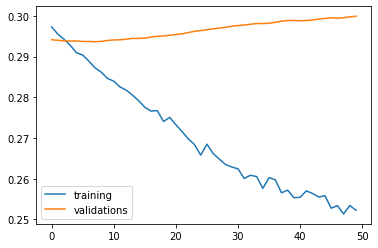

In [59]:
train = h.history['mean_absolute_error']
val = h.history['val_mean_absolute_error']

e = range(len(train))

plt.plot(e, train, label='training')
plt.plot(e, val, label="validations")
plt.legend()
plt.show()

### Evaluasi Model

Evaluasi dilakukan untuk mengetahui bagaimana tingkat error data sehingga bisa mengetau bagaimana performa dari data. Evaluasi menggunakan metrics MSE. 

\begin{align}
        \text{MAE } = (&\sum_{i=0}^n \mid y_i -y_i\mid) /n
    \end{align}

In [60]:
ypred = model.predict(val_user)
mae = mean_absolute_error(val_rating, ypred)
print(mae)

0.3130909373164177


nilai mae yang di dapatkan tidak terlalu tinggi sehingga data ini cocok untuk digunakan dalam sistem rekomendasi, tetapi mae dengan nilai 31% terbilang cukup tinggi sehingga bisa mengakibatkan overfitting data

### System Rekomendation from user

data yang digunakan untuk proses ini diambil dari data yang sudah disimpan dalam directory pada proses data processing pada teknik content based learning



In [61]:
place = data_dict

rate = pd.read_csv('/content/destination_tourism/tourism_rating.csv')
place.head(3)

,place_id,place_name,place_city,place_category
0,179,Candi Ratu Boko,Yogyakarta,Budaya
1,344,Pantai Marina,Semarang,Bahari
2,5,Atlantis Water Adventure,Jakarta,Taman Hiburan


Data akan diambil sampel 1 data yang digunakan diambil dari data nomer 2, lalu data tersebut nantinya id nya akan dibandingkan id user sehingga bisa meghasikan rekomendasi tempat wisata,

Data tersebut nantinya akan dibagi menjadi lokasi yang pernah dikunjungi dan lokasi yang tidak pernah dikunjungi sebelumnya.

In [62]:
#user = input("Masukkan user id ")
user = rate.User_Id.sample(2).iloc[0]
print(user)
place_visited = rate[rate.User_Id == user]

place_not = place[~place['place_id'].isin(place_visited.Place_Id.values)]['place_id']
place_not = list(
    set(place_not)
    .intersection(set(encode_place.keys()))
)
place_not = [[place_encode.get(a)] for a in place_not]
user_recomm = user_encode.get(user)
user_array = np.hstack(([[user_recomm]] * len(place_not), place_not))

284


Dilihat bahwa id yang diambil adalah 284 id tersebut melakukan penilaian ke beberapa tempat dengan nilai rating yang berbeda-beda

In [63]:
place_visited

,User_Id,Place_Id,Place_Ratings
9426,284,59,1
9427,284,94,2
9428,284,437,1
9429,284,436,1
9430,284,134,4
9431,284,360,3
9432,284,410,2
9433,284,166,2
9434,284,158,4
9435,284,273,3


In [64]:
predict = model.predict(user_array).flatten()

top_rate = predict.argsort()[-5:][::-1]
recomended_place = [
                    place_encode.get(place_not[a][0]) for a in top_rate
]

print(f' Rekomendasi dari user ber id : {user}')

print('---' * 10)
print("rekomendasi user dengan nilai rating tertinggi ")

top_place = (
    place_visited.sort_values(by= 'Place_Ratings')
).head(1).Place_Id.values

top_row = place[place['place_id'].isin(top_place)]
for r in top_row.itertuples():
  print(r.place_name, ':', r.place_city)

print('----' * 10)

recomended_top_rating = place[place['place_id'].isin(recomended_place)]
for r in recomended_top_rating.itertuples():
  print(r.place_name, ':', r.place_city)

 Rekomendasi dari user ber id : 284
------------------------------
rekomendasi user dengan nilai rating tertinggi 
Museum Sumpah Pemuda : Jakarta
----------------------------------------
Gunung Lalakon : Bandung
Taman Pelangi Yogyakarta : Yogyakarta
The Lost World Castle : Yogyakarta
Saung Angklung Mang Udjo : Bandung
Taman Mundu : Surabaya


karena sistem rekomendasi yang sudah di setting dengan hanya menampilkan 5 data saja maka data rekomendasi hanya 5 data diambil berdasarkan rating tertinggi dari user terhadap tempat-tempat wisata tersebut